In [1]:
import pandas as pd
import numpy as np
import urllib.request 
import urllib.parse
import urllib.error
import ssl
import re
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup as BS
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from statistics import median
import statsmodels.formula.api as sm
from sklearn.neural_network import MLPRegressor 
from sklearn.preprocessing import StandardScaler

from mord import LogisticIT

from dmba import classificationSummary, regressionSummary
from dmba import classificationSummary, gainsChart, liftChart

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from dmba import plotDecisionTree, classificationSummary, regressionSummary

import matplotlib.pylab as plt
%matplotlib inline

In [2]:
df1 = pd.read_csv("Cleaned_data.csv")

In [3]:
df1.columns

Index(['List_price', 'Address', 'City', 'State', 'Beds', 'Baths',
       'Living_sqft', 'Property_Type', 'Year_Built', 'Est__Mo__Payment',
       'Price_Sq_Ft_', 'Drought_Score', 'Walk_score', 'Neighbourhood_Homes',
       'Transit_score', 'Groceries_stores', 'Services', 'Emergency',
       'Shopping', 'Food_and_Drink', 'Competitive_Score', 'has_supercenter',
       'has_major_indian_grocery', 'has_major_entertainment',
       'has_indian_restaurant', 'has_chinese_restaurant',
       'has_mexican_restaurant', 'has_boba', 'has_starbucks', 'property_url',
       'has_mall', 'Zipcode', 'No_of_Schools', 'Average_rating', 'County'],
      dtype='object')

In [4]:
len(df1.columns)

35

In [5]:
df1.shape

(2213, 35)

In [6]:
c = df1.corr()
correlation=c["List_price"].sort_values(ascending=False)
correlation=pd.DataFrame(correlation)
correlation

,List_price
List_price,1.000000
Est__Mo__Payment,0.999362
Living_sqft,0.715915
Price_Sq_Ft_,0.663444
Baths,0.532644
Beds,0.521508
Competitive_Score,0.242802
Average_rating,0.166675
has_major_entertainment,0.121357
Services,0.111544


C:\Users\stsc.LENOVO-127992\AppData\Local\Temp\ipykernel_17264\3615923339.py:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  plots[0].set_xticklabels(correlation.index, rotation=90,fontsize='small')


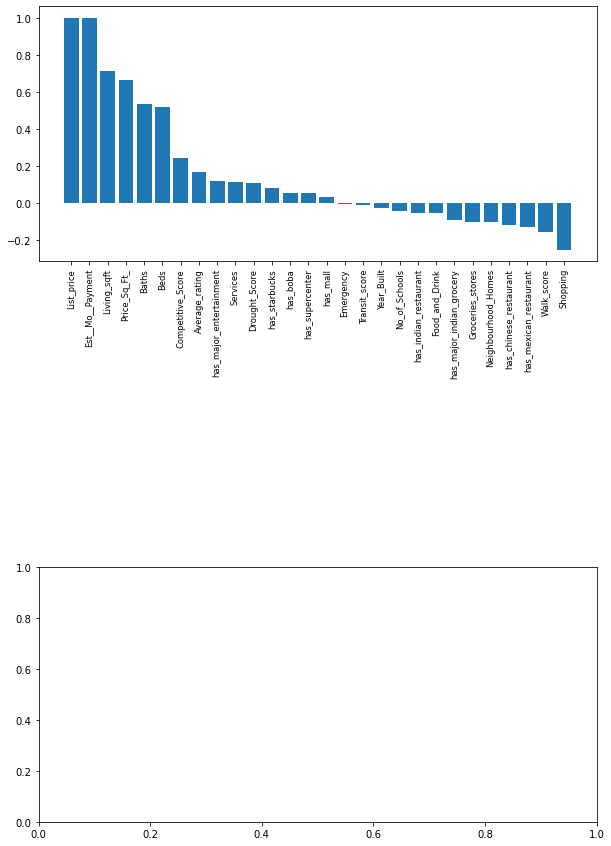

In [7]:
#Using matplotlib plt.subplots
fig, plots = plt.subplots(2,1)
plots[0].bar(correlation.index, correlation['List_price'],align='center')
plots[0].set_xticklabels(correlation.index, rotation=90,fontsize='small')
plt.subplots_adjust(hspace = 1.2)
fig.set_figwidth(10)
fig.set_figheight(15)
plt.show()

In [8]:
df1 = df1.drop(columns = ['Est__Mo__Payment']) #dropping Est__Mo__Payment column because it is dependent on list_price
 

In [9]:
#Checking the Walk_score variable because the correlation is counter intuitive. Hence the variable is converted 
#to category using the following classes and Walk_score_cat column is created
df1.loc[(df1.Walk_score >= 0) & (df1.Walk_score <= 49), 'Walk_score_cat'] = 'Car Dependent'
df1.loc[(df1.Walk_score >= 50) & (df1.Walk_score <= 69), 'Walk_score_cat'] = 'Somewhat Walkable'
df1.loc[(df1.Walk_score >= 70) & (df1.Walk_score <= 89), 'Walk_score_cat'] = 'Very Walkable'
df1.loc[(df1.Walk_score >= 90) & (df1.Walk_score <= 100), 'Walk_score_cat'] = 'Walkers Paradise'


In [10]:
df1.Walk_score_cat.value_counts()

Car Dependent        980
Somewhat Walkable    740
Very Walkable        439
Walkers Paradise      54
Name: Walk_score_cat, dtype: int64

In [11]:
#As we have Walk_score_cat catogory variable column, dropping Walk_score numerical column
df1 = df1.drop(columns = ["Walk_score"])

In [12]:
# 90–100	Walker's Paradise
# Daily errands do not require a car.
# 70–89	Very Walkable
# Most errands can be accomplished on foot.
# 50–69	Somewhat Walkable
# Some errands can be accomplished on foot.
# 25–49	Car-Dependent
# Most errands require a car.
# 0–24	Car-Dependent
# Almost all errands require a car


#https://www.redfin.com/how-walk-score-works ----- link for walk score catogories according to Redfin website

In [13]:
#Checking the Transit_score variable because the correlation is counter intuitive. Hence the variable is converted 
#to category using the following classes and Transit_score_cat column is created
df1.loc[(df1.Transit_score >= 0) & (df1.Transit_score <= 24), 'Transit_score_cat'] = 'Minimal Transit'
df1.loc[(df1.Transit_score >= 25) & (df1.Transit_score <= 49), 'Transit_score_cat'] = 'Some Transit'
df1.loc[(df1.Transit_score >= 50) & (df1.Transit_score <= 69), 'Transit_score_cat'] = 'Good Transit'
df1.loc[(df1.Transit_score >= 70) & (df1.Transit_score <= 89), 'Transit_score_cat'] = 'Excellent Transit'
df1.loc[(df1.Transit_score >= 90) & (df1.Transit_score <= 100), 'Transit_score_cat'] = 'Riders Paradise'

In [14]:
df1.Transit_score_cat.value_counts()

Good Transit    2213
Name: Transit_score_cat, dtype: int64

In [15]:
## All the records have transit score catogory as "Good Transit", no influence on the list price. hence dropping this column
df1 = df1.drop(columns = ['Transit_score_cat', "Transit_score"])

In [16]:
df1.to_csv("Data_cleaned.csv", index = False)

In [17]:
# 90–100	Rider's Paradise
# World-class public transportation.
# 70–89	Excellent Transit
# Transit is convenient for most trips.
# 50–69	Good Transit
# Many nearby public transportation options.
# 25–49	Some Transit
# A few nearby public transportation options.
# 0–24	Minimal Transit
# It is possible to get on a bus.

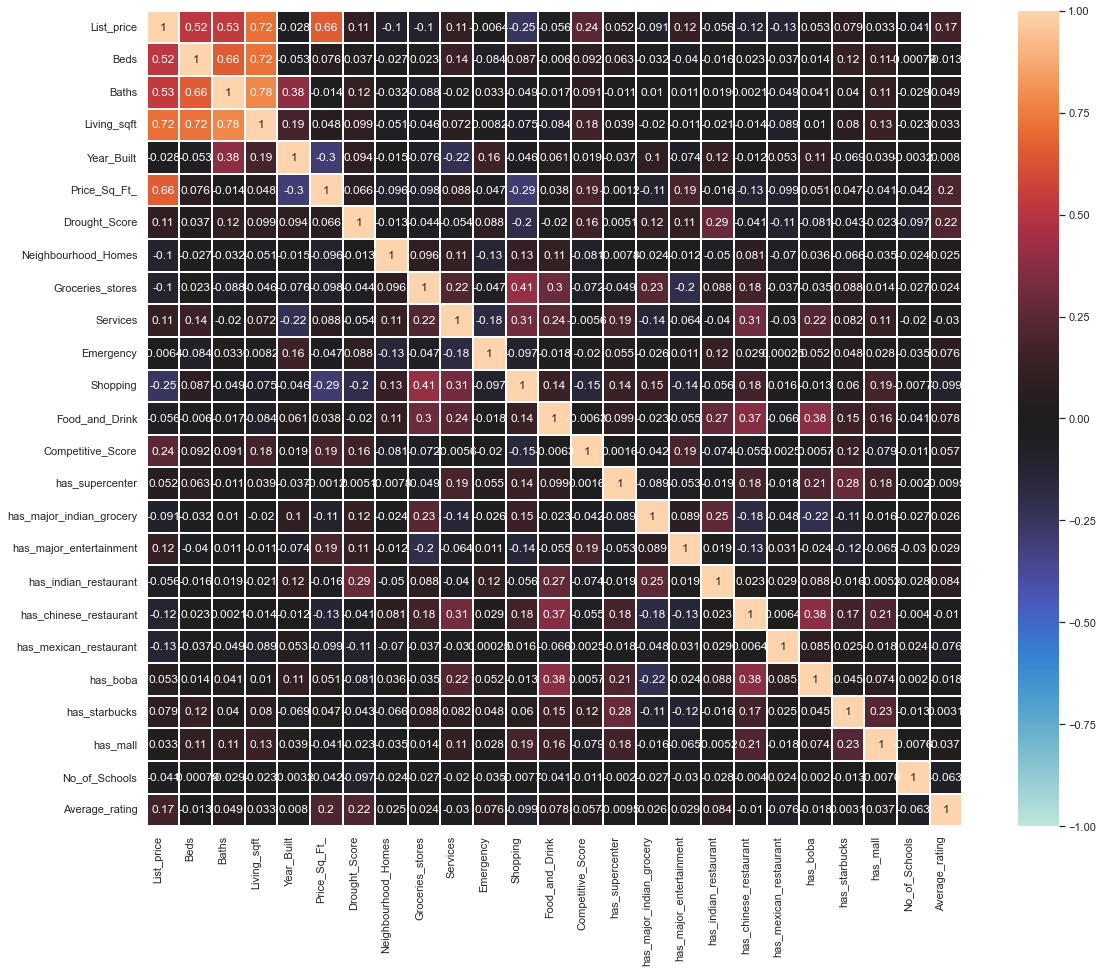

In [18]:
#heatmap for finding the correlated variables or checking for multicollinearity
#dropping the object datatype columns

data = df1.drop(columns=['Address', 'City', 'State', 'Zipcode', 'County', 'Property_Type']) 
corr = data.corr()
sns.set(rc = {'figure.figsize':(20,15)})
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
#     cmap=sns.diverging_palette(2, 500, n=200),
    square=True,
    annot = True,linewidths=.2
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

In [19]:
# Removing those variables which are correlated to each other
#Shopping is correlated with Grocery stores
#has_Boba with Food& drink
#has boba with has chinese restaurant

In [20]:
#dropping groceries_stores, Food&drink, shopping
df1.drop(columns=['Groceries_stores', 'Shopping', 'Food_and_Drink', 'Services'], inplace = True)

In [21]:
len(df1.columns)

29

C:\Users\stsc.LENOVO-127992\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


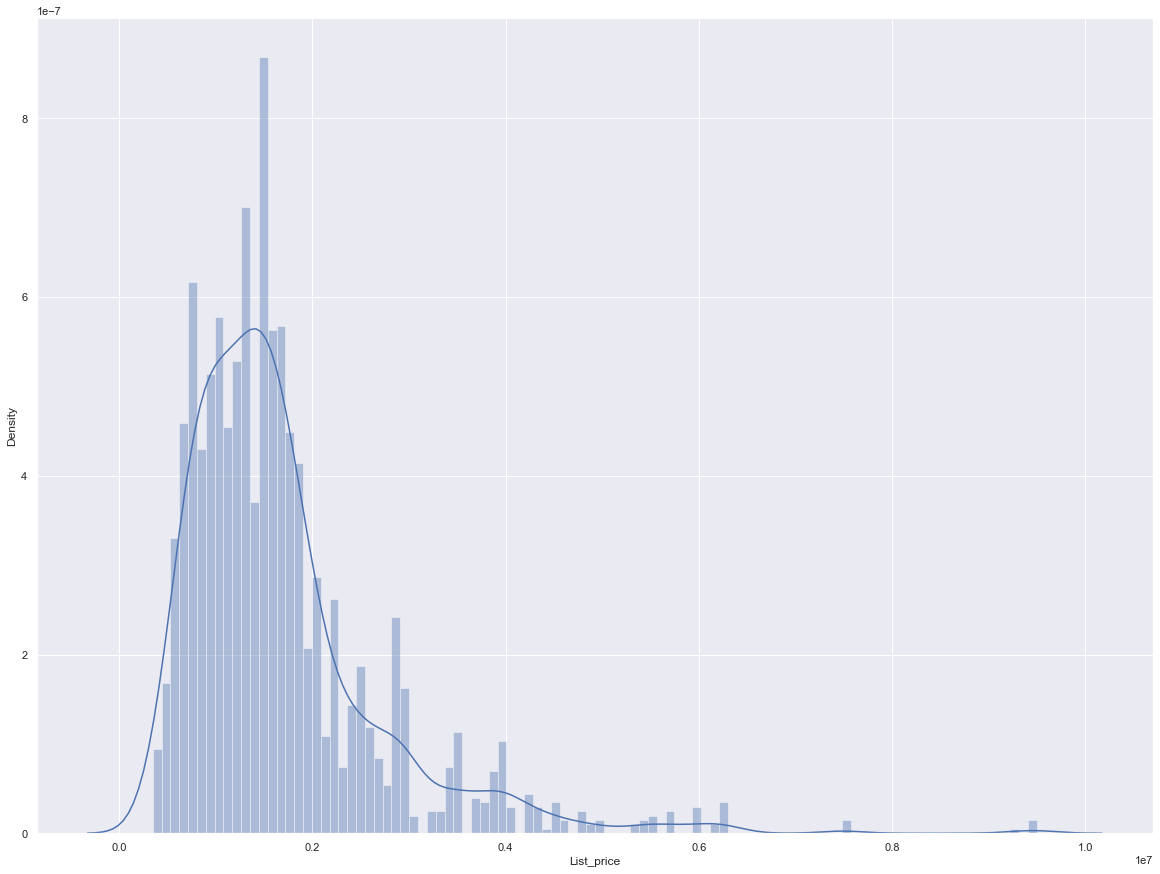

In [22]:
#checking the distribution of listprice
sns.distplot(df1['List_price'], color='b', bins=100, hist_kws={'alpha': 0.4})
sns.set(rc = {'figure.figsize':(6,6)})

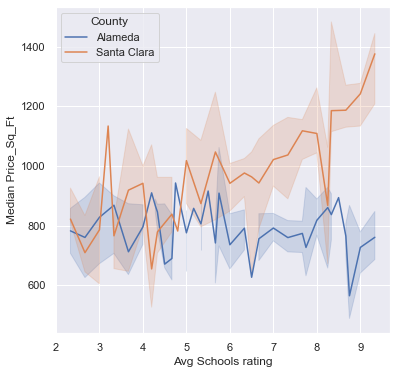

In [23]:
#analysing the varaition of average rating over the median price per sqft.
sns.lineplot(x = "Average_rating", y = 'Price_Sq_Ft_', data=df1, estimator = median, hue = 'County')
sns.set(rc = {'figure.figsize':(6,6)})
# plt.title('Opening Prices')
plt.xlabel('Avg Schools rating')
plt.ylabel('Median Price_Sq_Ft')
plt.show()

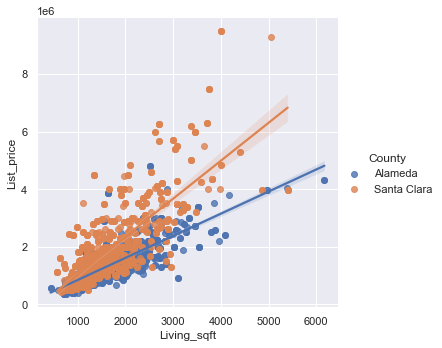

In [24]:
#Analysis the variation of the list price with the living sqft, county wise.
sns.lmplot(x = "Living_sqft", y = 'List_price', data=df1, hue = "County")
sns.set(rc = {'figure.figsize':(6,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
# plt.ylabel('Opening Price')
plt.show()

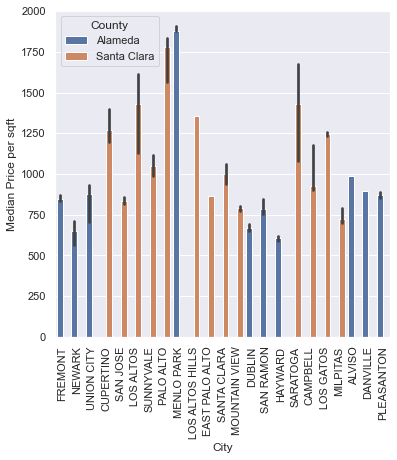

In [25]:
#analysing the median price per sqft over the cities and counties
from numpy import median
sns.barplot(x = "City", y = 'Price_Sq_Ft_', data=df1, hue = "County", estimator = median)
sns.set(rc = {'figure.figsize':(8,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
plt.ylabel('Median Price per sqft')
plt.xticks(rotation=90)
plt.show()

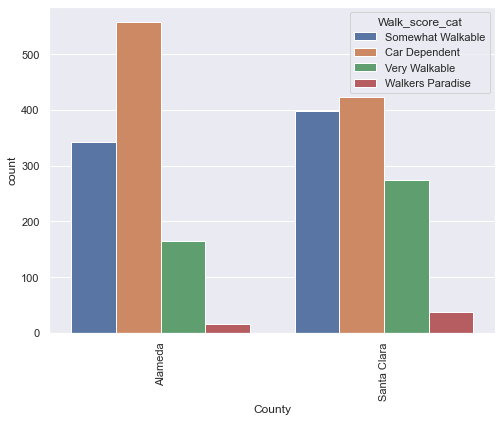

In [26]:
# analysing the walk score, county wise
sns.countplot(x ='County', hue = "Walk_score_cat", data = df1)
# plt.title('Opening Prices')
# plt.xlabel('Date')
# plt.ylabel('Opening Price')
sns.set(rc = {'figure.figsize':(6,6)})
plt.xticks(rotation=90)
plt.show()

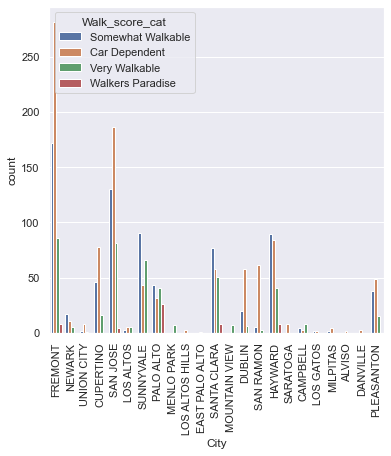

In [27]:
#analysing the walk sscore city wise
sns.countplot(x ='City', hue = "Walk_score_cat", data = df1)
# plt.title('Opening Prices')
# plt.xlabel('Date')
# plt.ylabel('Opening Price')
sns.set(rc = {'figure.figsize':(25,6)})
plt.xticks(rotation=90)
plt.show()

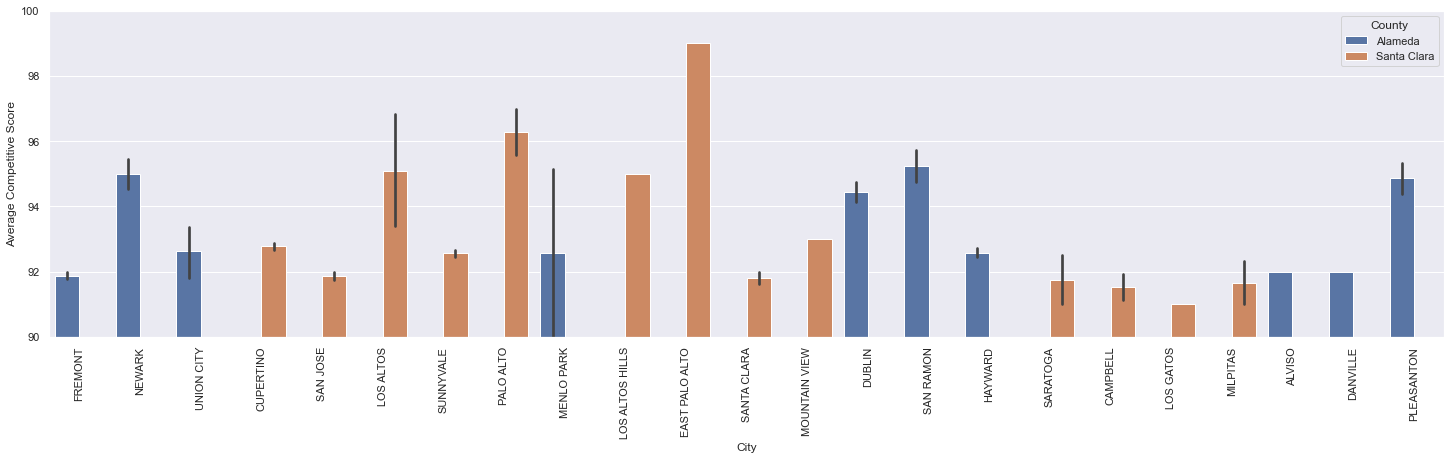

In [28]:
#analysing the competitive score variation over the cities
gfg = sns.barplot(x = "City", y = 'Competitive_Score', data=df1, hue = "County")
gfg.set_ylim(90, 100)
sns.set(rc = {'figure.figsize':(10,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
plt.ylabel('Average Competitive Score')
plt.xticks(rotation=90)
plt.show()



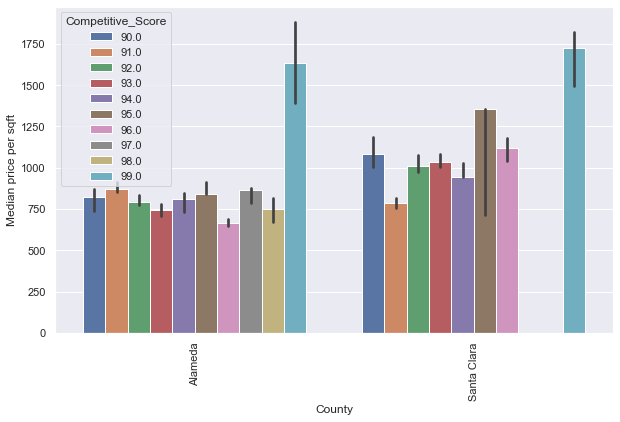

In [29]:
#Analysisng the compettive score accreoos the counties with median price per sqft
sns.barplot(x = "County", y = 'Price_Sq_Ft_', data=df1, hue = "Competitive_Score", estimator =median)
sns.set(rc = {'figure.figsize':(10,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
plt.ylabel('Median price per sqft')
plt.xticks(rotation=90)
plt.show()

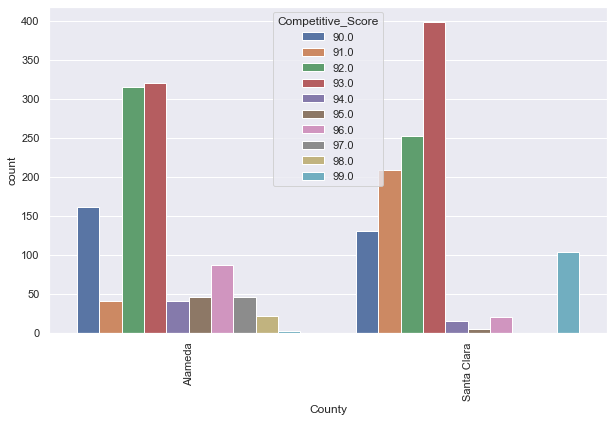

In [30]:
#Analysisng the cmpetetive score with the count across two counties.
sns.countplot(x = "County", data=df1, hue = "Competitive_Score")
sns.set(rc = {'figure.figsize':(10,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
# plt.ylabel('Average price per sqft')
plt.xticks(rotation=90)
plt.show()

### Analysing whether the presence of any supercenter, mall, boba shop, starbucks are affecting the prices across two counties

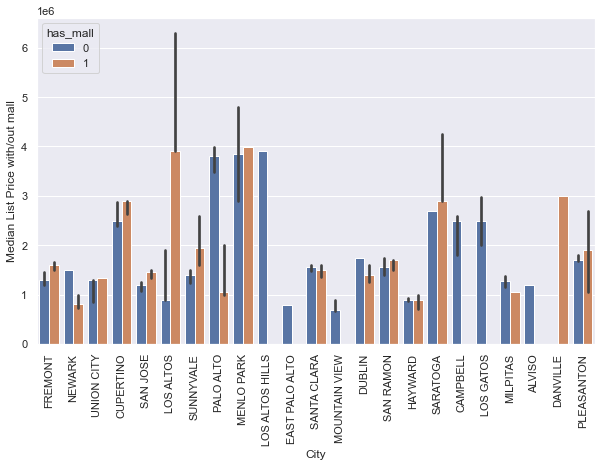

In [31]:
sns.barplot(x = "City", y = 'List_price', data=df1, hue = "has_mall", estimator =median)
sns.set(rc = {'figure.figsize':(10,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
plt.ylabel('Median List Price with/out mall')
plt.xticks(rotation=90)
plt.show()

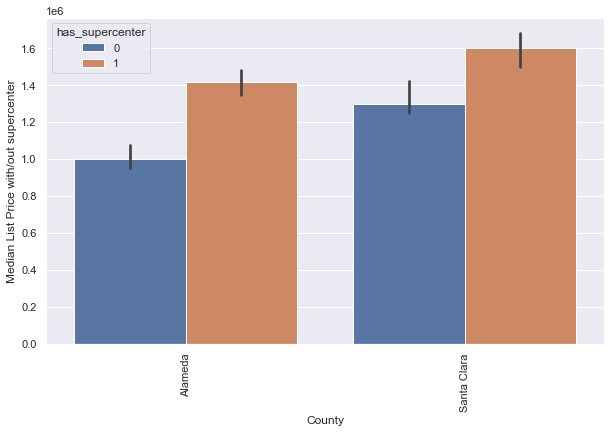

In [32]:

sns.barplot(x = "County", y = 'List_price', data=df1, hue = "has_supercenter", estimator =median)
sns.set(rc = {'figure.figsize':(6,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
plt.ylabel('Median List Price with/out supercenter')
plt.xticks(rotation=90)
plt.show()

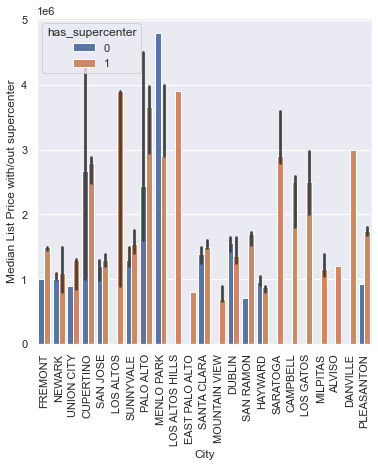

In [33]:
sns.barplot(x = "City", y = 'List_price', data=df1, hue = "has_supercenter", estimator =median)
sns.set(rc = {'figure.figsize':(10,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
plt.ylabel('Median List Price with/out supercenter')
plt.xticks(rotation=90)
plt.show()

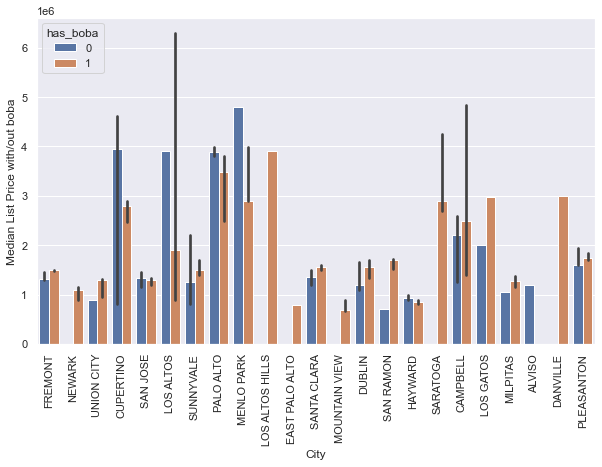

In [34]:
sns.barplot(x = "City", y = 'List_price', data=df1, hue = "has_boba", estimator =median)
sns.set(rc = {'figure.figsize':(10,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
plt.ylabel('Median List Price with/out boba')
plt.xticks(rotation=90)
plt.show()

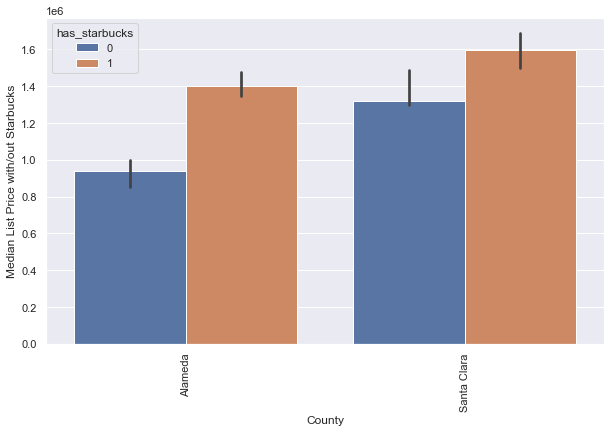

In [35]:
sns.barplot(x = "County", y = 'List_price', data=df1, hue = "has_starbucks", estimator =median)
sns.set(rc = {'figure.figsize':(6,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
plt.ylabel('Median List Price with/out Starbucks')
plt.xticks(rotation=90)
plt.show()

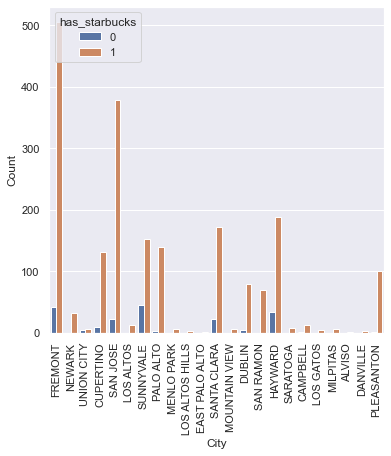

In [36]:
sns.countplot(x = "City", data=df1, hue = "has_starbucks")
sns.set(rc = {'figure.figsize':(10,6)})
# plt.title('Opening Prices')
# plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [37]:
df1.dtypes

List_price                  float64
Address                      object
City                         object
State                        object
Beds                        float64
Baths                       float64
Living_sqft                 float64
Property_Type                object
Year_Built                  float64
Price_Sq_Ft_                float64
Drought_Score               float64
Neighbourhood_Homes         float64
Emergency                     int64
Competitive_Score           float64
has_supercenter               int64
has_major_indian_grocery      int64
has_major_entertainment       int64
has_indian_restaurant         int64
has_chinese_restaurant        int64
has_mexican_restaurant        int64
has_boba                      int64
has_starbucks                 int64
property_url                 object
has_mall                      int64
Zipcode                      object
No_of_Schools               float64
Average_rating              float64
County                      

In [38]:
df1.shape

(2213, 29)

## One hot Encoding

In [39]:
# The column is 'object'; does not have 
# the 'category' definition.

# Need to change object variable type to 'category'. 
colslist = ['Property_Type', 'County', 'Walk_score_cat']
for i in colslist:
    df1[i] = df1[i].astype('category')
    print(df1[i].cat.categories)
    print(df1[i].dtype)

One_hot_Property_Type = pd.get_dummies(df1['Property_Type'], prefix = 'Property_Type', prefix_sep ='_', 
                            drop_first=True)
One_hot_County = pd.get_dummies(df1['County'],prefix ='County',  prefix_sep='_', 
                            drop_first=True)
One_hot_Walk_score_cat = pd.get_dummies(df1['Walk_score_cat'], prefix = 'Walk_score_cat', prefix_sep='_', 
                            drop_first=True)

# # Display category levels (attributes) and category type.
# print(' ')
# print('Category levels and changed variable type:')
# print(df1.County.cat.categories)  # It can take one of three levels.
# print(df1.County.dtype)  # Type is now 'category'.

Index(['Condo', 'Single', 'Townhouse'], dtype='object')
category
Index(['Alameda', 'Santa Clara'], dtype='object')
category
Index(['Car Dependent', 'Somewhat Walkable', 'Very Walkable',
       'Walkers Paradise'],
      dtype='object')
category


In [40]:
df_new = pd.concat([df1.drop(['Walk_score_cat', 'Property_Type', 'County'],axis = 1), One_hot_Walk_score_cat, One_hot_Property_Type, One_hot_County], axis = 1)

In [41]:
df_new.columns

Index(['List_price', 'Address', 'City', 'State', 'Beds', 'Baths',
       'Living_sqft', 'Year_Built', 'Price_Sq_Ft_', 'Drought_Score',
       'Neighbourhood_Homes', 'Emergency', 'Competitive_Score',
       'has_supercenter', 'has_major_indian_grocery',
       'has_major_entertainment', 'has_indian_restaurant',
       'has_chinese_restaurant', 'has_mexican_restaurant', 'has_boba',
       'has_starbucks', 'property_url', 'has_mall', 'Zipcode', 'No_of_Schools',
       'Average_rating', 'Walk_score_cat_Somewhat Walkable',
       'Walk_score_cat_Very Walkable', 'Walk_score_cat_Walkers Paradise',
       'Property_Type_Single', 'Property_Type_Townhouse',
       'County_Santa Clara'],
      dtype='object')

In [42]:
df_new.dtypes

List_price                          float64
Address                              object
City                                 object
State                                object
Beds                                float64
Baths                               float64
Living_sqft                         float64
Year_Built                          float64
Price_Sq_Ft_                        float64
Drought_Score                       float64
Neighbourhood_Homes                 float64
Emergency                             int64
Competitive_Score                   float64
has_supercenter                       int64
has_major_indian_grocery              int64
has_major_entertainment               int64
has_indian_restaurant                 int64
has_chinese_restaurant                int64
has_mexican_restaurant                int64
has_boba                              int64
has_starbucks                         int64
property_url                         object
has_mall                        

In [43]:
df_new.to_csv('Analysis_data.csv', index = False)

In [44]:
price_df = pd.read_csv('Analysis_data.csv')

In [45]:
len(price_df.columns)

32

In [46]:
price_df.describe().columns

Index(['List_price', 'Beds', 'Baths', 'Living_sqft', 'Year_Built',
       'Price_Sq_Ft_', 'Drought_Score', 'Neighbourhood_Homes', 'Emergency',
       'Competitive_Score', 'has_supercenter', 'has_major_indian_grocery',
       'has_major_entertainment', 'has_indian_restaurant',
       'has_chinese_restaurant', 'has_mexican_restaurant', 'has_boba',
       'has_starbucks', 'has_mall', 'No_of_Schools', 'Average_rating',
       'Walk_score_cat_Somewhat Walkable', 'Walk_score_cat_Very Walkable',
       'Walk_score_cat_Walkers Paradise', 'Property_Type_Single',
       'Property_Type_Townhouse', 'County_Santa Clara'],
      dtype='object')

In [47]:
print('Modified column titles with no space and one word for titles:')
price_df.columns = [s.strip().replace(' ', '_') for s in price_df.columns]
price_df.columns

Modified column titles with no space and one word for titles:


Index(['List_price', 'Address', 'City', 'State', 'Beds', 'Baths',
       'Living_sqft', 'Year_Built', 'Price_Sq_Ft_', 'Drought_Score',
       'Neighbourhood_Homes', 'Emergency', 'Competitive_Score',
       'has_supercenter', 'has_major_indian_grocery',
       'has_major_entertainment', 'has_indian_restaurant',
       'has_chinese_restaurant', 'has_mexican_restaurant', 'has_boba',
       'has_starbucks', 'property_url', 'has_mall', 'Zipcode', 'No_of_Schools',
       'Average_rating', 'Walk_score_cat_Somewhat_Walkable',
       'Walk_score_cat_Very_Walkable', 'Walk_score_cat_Walkers_Paradise',
       'Property_Type_Single', 'Property_Type_Townhouse',
       'County_Santa_Clara'],
      dtype='object')

In [70]:
price_df.describe().columns

Index(['List_price', 'Beds', 'Baths', 'Living_sqft', 'Year_Built',
       'Price_Sq_Ft_', 'Drought_Score', 'Neighbourhood_Homes', 'Emergency',
       'Competitive_Score', 'has_supercenter', 'has_major_indian_grocery',
       'has_major_entertainment', 'has_indian_restaurant',
       'has_chinese_restaurant', 'has_mexican_restaurant', 'has_boba',
       'has_starbucks', 'has_mall', 'No_of_Schools', 'Average_rating',
       'Walk_score_cat_Somewhat_Walkable', 'Walk_score_cat_Very_Walkable',
       'Walk_score_cat_Walkers_Paradise', 'Property_Type_Single',
       'Property_Type_Townhouse', 'County_Santa_Clara'],
      dtype='object')

## Multiple Linear Regression model - without normalization because weights or the coeffecients are going take care of the domainance of variables with higher values over the variables with lower values 

## 5-Fold Cross validation

In [49]:
predictors = ['Beds', 'Baths', 'Living_sqft', 'Year_Built',
       'Price_Sq_Ft_', 'Drought_Score', 'Neighbourhood_Homes', 'Emergency',
       'Competitive_Score', 'has_supercenter', 'has_major_indian_grocery',
       'has_major_entertainment', 'has_indian_restaurant',
       'has_chinese_restaurant', 'has_mexican_restaurant', 'has_boba',
       'has_starbucks', 'has_mall', 'No_of_Schools', 'Average_rating',
       'Walk_score_cat_Somewhat_Walkable', 'Walk_score_cat_Very_Walkable',
       'Walk_score_cat_Walkers_Paradise', 'Property_Type_Single',
       'Property_Type_Townhouse', 'County_Santa_Clara']
outcome = 'List_price'



# Identify X and y variables for regression and partition data
# using 60% of records for training and 40% for validation 
# (test_size=0.4). 
X = price_df[predictors]
y = price_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
Regression = LinearRegression()

# Use cross_val_score() function to identify performance 
# accuracy for 5 folds (cv=5) of cross-validation partitioning.
scores = cross_val_score(Regression, train_X, train_y, cv=5)

# Display performance accuracy scores for each fold partition.
# Use three decimals (.3f) for each accuracy score using the 
# acc (accumulator) parameter. 
print('Performance Accuracy of 5-Fold Cross-Validation')
print('Accuracy scores of each fold: ', [f'{acc:.3f}' for acc in scores])

# Indetify and display two standard deviation confidence interval for 
# population mean scores.
print()
print('Two Standard Deviation (95%) Confidence Interval for Mean Accuracy')
print(f'Accuracy: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})')

Performance Accuracy of 5-Fold Cross-Validation
Accuracy scores of each fold:  ['0.896', '0.925', '0.915', '0.894', '0.908']

Two Standard Deviation (95%) Confidence Interval for Mean Accuracy
Accuracy: 0.908 (+/- 0.023)


## Multiple Linear Regression model - with all 26 variables

In [50]:
# Identify predictors and outcome of the regression model. Not including irrelevant columns
#'Address', 'City', 'State', 'zipcode' in regression 
#because these variables do not have any effect on the model
predictors = ['Beds', 'Baths', 'Living_sqft', 'Year_Built',
       'Price_Sq_Ft_', 'Drought_Score', 'Neighbourhood_Homes', 'Emergency',
       'Competitive_Score', 'has_supercenter', 'has_major_indian_grocery',
       'has_major_entertainment', 'has_indian_restaurant',
       'has_chinese_restaurant', 'has_mexican_restaurant', 'has_boba',
       'has_starbucks', 'has_mall', 'No_of_Schools', 'Average_rating',
       'Walk_score_cat_Somewhat_Walkable', 'Walk_score_cat_Very_Walkable',
       'Walk_score_cat_Walkers_Paradise', 'Property_Type_Single',
       'Property_Type_Townhouse', 'County_Santa_Clara']
outcome = 'List_price'



# Identify X and y variables for regression and partition data
# using 60% of records for training and 40% for validation 
# (test_size=0.4). 
X = price_df[predictors]
y = price_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# Create multiple linear regression model using X and y
# and LinearRegression() function from sklearn (skikit-learn) 
# library.
price_lm = LinearRegression()
price_lm.fit(train_X, train_y)
print("Training partition:", len(train_X),'\n'"Validation partition:", len(valid_X), '\n')

# Display intercept and regression coefficients. Round
# them to 2 decimals.
print('Regression Model for Prices Training Set')
print()
print('Intercept: ', np.round(price_lm.intercept_, 2))
print(pd.DataFrame({'Predictor': X.columns, 'Coefficient': np.round(price_lm.coef_, 2)}))

Training partition: 1327 
Validation partition: 886 

Regression Model for Prices Training Set

Intercept:  -1707772.56
                           Predictor  Coefficient
0                               Beds    -17082.81
1                              Baths     29381.11
2                        Living_sqft      1075.38
3                         Year_Built        34.10
4                       Price_Sq_Ft_      1693.12
5                      Drought_Score      2030.47
6                Neighbourhood_Homes      -314.52
7                          Emergency      5699.00
8                  Competitive_Score     -4393.03
9                    has_supercenter    128698.68
10          has_major_indian_grocery     -9390.14
11           has_major_entertainment     15291.38
12             has_indian_restaurant   -117036.73
13            has_chinese_restaurant   -116929.28
14            has_mexican_restaurant     16684.02
15                          has_boba     38717.67
16                     has_sta

In [51]:
# Use predict() to score (make) predictions for validation set.
price_lm_pred = price_lm.predict(valid_X)

# Develop and display data frame with actual values of Price,
# scoring (predicted) results, and residuals.
# Use round() function to round vlaues in data frame to 
# 2 decimals. 
print('Actual, Prediction, and Residual Prices for Validation Set\n\n')
result = round(pd.DataFrame({'Actual': valid_y,'Predicted': price_lm_pred, 
                       'Residual': valid_y - price_lm_pred}), 2)
print(result.head(15))

Actual, Prediction, and Residual Prices for Validation Set


         Actual   Predicted    Residual
1407  1650000.0  1632164.15    17835.85
1585  1348800.0  1274875.03    73924.97
1032  1750000.0  1862492.64  -112492.64
415   4050000.0  3789740.55   260259.45
201    349000.0   -91620.13   440620.13
194    799000.0   813910.35   -14910.35
1268  2388000.0  2393957.48    -5957.48
549   1298000.0  1179372.26   118627.74
126   1302195.0  1356370.07   -54175.07
363   2437000.0  4110331.96 -1673331.96
778   2499950.0  3380275.02  -880325.02
1751  1998000.0  2509266.51  -511266.51
702    948000.0   905954.75    42045.25
1362  1998800.0  2328900.53  -330100.53
1224   999888.0  1013384.78   -13496.78


In [52]:
# Use predict() function to make predictions for
# training set.
pred_y = price_lm.predict(train_X)

# Create prediction performance measures for training set.
r2 = round(r2_score(train_y, pred_y),3)
adj_r2 = round(adjusted_r2_score(train_y, pred_y, price_lm),3)


# Display prediction performance measures for training set.
print('Prediction Performance Measures for Training Set')
print('r2 : ', r2)
print('Adjusted r2 : ', adj_r2)

print() 

# Create prediction performance measures for validation set.
r2 = round(r2_score(valid_y, price_lm_pred),3)
adj_r2 = round(adjusted_r2_score(valid_y, price_lm_pred, price_lm),3)


# Display prediction performance measures for validation set.
print('Prediction Performance Measures for Validation Set')
print('r2 : ', r2)
print('adjusted r2 : ', adj_r2)

Prediction Performance Measures for Training Set
r2 :  0.912
Adjusted r2 :  0.91

Prediction Performance Measures for Validation Set
r2 :  0.927
adjusted r2 :  0.925


In [53]:
# Display common accuracy measures for training set.
print('Accuracy Measures for Training Set - All Variables')
regressionSummary(train_y, pred_y)
print()

# Display common accuracy measures for validation set.
print('Accuracy Measures for Validation Set - All Variables')
regressionSummary(valid_y, price_lm_pred)

Accuracy Measures for Training Set - All Variables

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 322849.3457
            Mean Absolute Error (MAE) : 194073.9406
          Mean Percentage Error (MPE) : 2.1051
Mean Absolute Percentage Error (MAPE) : 13.9432

Accuracy Measures for Validation Set - All Variables

Regression statistics

                      Mean Error (ME) : -12055.8340
       Root Mean Squared Error (RMSE) : 267077.8858
            Mean Absolute Error (MAE) : 178908.7909
          Mean Percentage Error (MPE) : 1.7451
Mean Absolute Percentage Error (MAPE) : 12.9972


In [54]:
# Create a data frame that inlcudes predictors and
# outcome (Price) for training set.
train_df_sm = train_X.join(train_y)

# Display columns in train_df data frame.
train_df_sm.columns

# Create predictors for the model.
predictors_sm = train_X.columns

# Develop regression model formula, where
# Price is outcome and 11 predictors. 
formula = 'train_y ~ ' + ' + '.join(predictors_sm)

# Create multiple regression model using sm.ols()
# function from statsmodels library.
price_lm_sm = sm.ols(formula=formula, data=train_df_sm).fit()

# Display regression summary.
print(price_lm_sm.summary()) 

# The regression coefficients are the same as for the 
# regression model using LinearRegression() function 
# from scikit-learn library.

                            OLS Regression Results                            
Dep. Variable:                train_y   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     515.4
Date:                Sun, 15 May 2022   Prob (F-statistic):               0.00
Time:                        20:22:57   Log-Likelihood:                -18716.
No. Observations:                1327   AIC:                         3.749e+04
Df Residuals:                    1300   BIC:                         3.763e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

## Backward elimination algorithm

In [55]:
# Define train_model() function used in Backward Elimination
# algorithm with backward_elimination() function. 
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

# Define score_model() function used in Backward Elimination
# algorithm with backward_elimination() function. 
def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

# Use backward_elimination() function to identify the
# best_model and best_variables. 
best_model_be, best_variables_be = backward_elimination(train_X.columns, 
                        train_model, score_model, verbose=True)

# Display best variables based on Backward Elimination algorithm. 
print()
print('Best Variables from Backward Elimination Algorithm')
print(best_variables_be)

Variables: Beds, Baths, Living_sqft, Year_Built, Price_Sq_Ft_, Drought_Score, Neighbourhood_Homes, Emergency, Competitive_Score, has_supercenter, has_major_indian_grocery, has_major_entertainment, has_indian_restaurant, has_chinese_restaurant, has_mexican_restaurant, has_boba, has_starbucks, has_mall, No_of_Schools, Average_rating, Walk_score_cat_Somewhat_Walkable, Walk_score_cat_Very_Walkable, Walk_score_cat_Walkers_Paradise, Property_Type_Single, Property_Type_Townhouse, County_Santa_Clara
Start: score=37487.70
Step: score=37485.70, remove Year_Built
Step: score=37483.76, remove Neighbourhood_Homes
Step: score=37481.89, remove Drought_Score
Step: score=37480.04, remove has_mexican_restaurant
Step: score=37478.22, remove has_major_indian_grocery
Step: score=37476.64, remove No_of_Schools
Step: score=37475.22, remove County_Santa_Clara
Step: score=37473.93, remove has_major_entertainment
Step: score=37472.62, remove Property_Type_Townhouse
Step: score=37471.32, remove Walk_score_cat_Wa

## Multiple linear regression with best variables from Backward Elimination Algorithm

In [56]:
predictors = ['Living_sqft', 'Price_Sq_Ft_', 'Emergency', 'has_supercenter', 'has_indian_restaurant', 
              'has_chinese_restaurant', 'has_boba', 'has_mall', 'Average_rating',
              'Walk_score_cat_Somewhat_Walkable', 'Walk_score_cat_Very_Walkable', 'Property_Type_Single']
outcome = 'List_price'

# Identify X and y variables for regression and partition data
# using 60% of records for training and 40% for validation 
# (test_size=0.4). 
X = price_df[predictors]
y = price_df[outcome]
train_X_be, valid_X_be, train_y_be, valid_y_be = train_test_split(X, y, test_size=0.4, random_state=1)

# Create multiple linear regression model using X and y
# and LinearRegression() function from sklearn (skikit-learn) 
# library.
price_lm_be = LinearRegression()
price_lm_be.fit(train_X_be, train_y_be)

# Display intercept and regression coefficients. Round
# them to 2 decimals.
print('Regression Model for Prices Training Set based on Backward elimination algorithm')
print()
print('Intercept: ', np.round(price_lm_be.intercept_, 2))
print(pd.DataFrame({'Predictor': X.columns, 'Coefficient': np.round(price_lm_be.coef_, 2)}))


Regression Model for Prices Training Set based on Backward elimination algorithm

Intercept:  -1855199.88
                           Predictor  Coefficient
0                        Living_sqft      1088.19
1                       Price_Sq_Ft_      1709.48
2                          Emergency      6081.12
3                    has_supercenter    133746.17
4              has_indian_restaurant   -119925.13
5             has_chinese_restaurant   -117520.28
6                           has_boba     43114.36
7                           has_mall    -90090.98
8                     Average_rating     18454.07
9   Walk_score_cat_Somewhat_Walkable     55334.16
10      Walk_score_cat_Very_Walkable     78066.96
11              Property_Type_Single   -150168.47


In [57]:
# Living_sqft,Price_Sq_Ft_,Emergency,has_supercenter,has_indian_restaurant,has_chinese_restaurant,has_mall,Average_rating,Walk_score_cat_Walkers_Paradise,Property_Type_Single
# Use predict() to score (make) predictions for validation set.
price_lm_pred_be = price_lm_be.predict(valid_X_be)

# Develop and display data frame with actual values of Price,
# scoring (predicted) results, and residuals.
# Use round() function to round vlaues in data frame to 
# 2 decimals. 
print('Actual, Prediction, and Residual Prices for Validation Set based on Backward elimination algorithm\n\n')
result = round(pd.DataFrame({'Actual': valid_y_be,'Predicted': price_lm_pred_be, 
                       'Residual': valid_y_be - price_lm_pred_be}), 2)
print(result.head(15))

Actual, Prediction, and Residual Prices for Validation Set based on Backward elimination algorithm


         Actual   Predicted    Residual
1407  1650000.0  1611040.02    38959.98
1585  1348800.0  1237523.13   111276.87
1032  1750000.0  1861345.72  -111345.72
415   4050000.0  3770626.18   279373.82
201    349000.0   -95851.50   444851.50
194    799000.0   829437.83   -30437.83
1268  2388000.0  2412768.30   -24768.30
549   1298000.0  1207580.93    90419.07
126   1302195.0  1379070.15   -76875.15
363   2437000.0  4065557.96 -1628557.96
778   2499950.0  3352552.12  -852602.12
1751  1998000.0  2484563.90  -486563.90
702    948000.0   920380.09    27619.91
1362  1998800.0  2322694.55  -323894.55
1224   999888.0  1057450.86   -57562.86


In [58]:
# Use predict() function to make predictions for
# training set.
pred_y_be = price_lm_be.predict(train_X_be)

# Create prediction performance measures for training set.
r2 = round(r2_score(train_y_be, pred_y_be),3)
adj_r2 = round(adjusted_r2_score(train_y_be, pred_y_be, price_lm_be),3)


# Display prediction performance measures for training set.
print('Prediction Performance Measures for Training Set based on Backward elimination algorithm ')
print('r2 : ', r2)
print('Adjusted r2 : ', adj_r2)

print() 

# Create prediction performance measures for validation set.
r2 = round(r2_score(valid_y_be, price_lm_pred_be),3)
adj_r2 = round(adjusted_r2_score(valid_y_be, price_lm_pred_be, price_lm_be),3)


# Display prediction performance measures for validation set.
print('Prediction Performance Measures for Validation Set based on Backward elimination algorithm')
print('r2 : ', r2)
print('adjusted r2 : ', adj_r2)


Prediction Performance Measures for Training Set based on Backward elimination algorithm 
r2 :  0.911
Adjusted r2 :  0.91

Prediction Performance Measures for Validation Set based on Backward elimination algorithm
r2 :  0.926
adjusted r2 :  0.925


In [59]:
# Display common accuracy measures for training set.
print('Accuracy Measures for Training Set based on Backward elimination algorithm')
regressionSummary(train_y_be, pred_y_be)
print()

# Display common accuracy measures for validation set.
print('Accuracy Measures for Validation Set based on Backward elimination algorithm')
regressionSummary(valid_y_be, price_lm_pred_be)

Accuracy Measures for Training Set based on Backward elimination algorithm

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 323866.5611
            Mean Absolute Error (MAE) : 194572.1751
          Mean Percentage Error (MPE) : 2.0949
Mean Absolute Percentage Error (MAPE) : 13.9218

Accuracy Measures for Validation Set based on Backward elimination algorithm

Regression statistics

                      Mean Error (ME) : -13714.1137
       Root Mean Squared Error (RMSE) : 268675.0587
            Mean Absolute Error (MAE) : 180650.3527
          Mean Percentage Error (MPE) : 1.6380
Mean Absolute Percentage Error (MAPE) : 13.0804


## Neural Network model

In [60]:
predictors = ['Beds', 'Baths', 'Living_sqft', 'Year_Built',
       'Price_Sq_Ft_', 'Drought_Score', 'Neighbourhood_Homes', 'Emergency',
       'Competitive_Score', 'has_supercenter', 'has_major_indian_grocery',
       'has_major_entertainment', 'has_indian_restaurant',
       'has_chinese_restaurant', 'has_mexican_restaurant', 'has_boba',
       'has_starbucks', 'has_mall', 'No_of_Schools', 'Average_rating',
       'Walk_score_cat_Somewhat_Walkable', 'Walk_score_cat_Very_Walkable',
       'Walk_score_cat_Walkers_Paradise', 'Property_Type_Single',
       'Property_Type_Townhouse', 'County_Santa_Clara']
outcome = 'List_price'



# Identify X and y variables for regression and partition data
# using 60% of records for training and 40% for validation 
# (test_size=0.4). 
X = price_df[predictors]
y = price_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# Scale input data (predictors) for training  and validation 
# partitions using StandardScaler().
sc_X = StandardScaler()
train_X_sc = sc_X.fit_transform(train_X)
valid_X_sc = sc_X.transform(valid_X) 

# Develop a data frame to display scaled predictors for 
# training partition. Round scaled values to 3 decimals.
# Add coloumn titles to data frame.
train_X_sc_df = np.round(pd.DataFrame(train_X_sc), decimals=3)                            
train_X_sc_df.columns= ['Beds', 'Baths', 'Living_sqft', 'Year_Built',
       'Price_Sq_Ft_', 'Drought_Score', 'Neighbourhood_Homes', 'Emergency',
       'Competitive_Score', 'has_supercenter', 'has_major_indian_grocery',
       'has_major_entertainment', 'has_indian_restaurant',
       'has_chinese_restaurant', 'has_mexican_restaurant', 'has_boba',
       'has_starbucks', 'has_mall', 'No_of_Schools', 'Average_rating',
       'Walk_score_cat_Somewhat_Walkable', 'Walk_score_cat_Very_Walkable',
       'Walk_score_cat_Walkers_Paradise', 'Property_Type_Single',
       'Property_Type_Townhouse', 'County_Santa_Clara']

# Display scaled predictors for training partition.
print()
print('Scaled Predictors for Training Partition')
print(train_X_sc_df.head(5))


Scaled Predictors for Training Partition
    Beds  Baths  Living_sqft  Year_Built  Price_Sq_Ft_  Drought_Score  \
0  0.814 -0.408       -0.253      -0.551         0.036         -2.157   
1 -0.119 -0.408       -0.520      -0.704        -0.544          0.393   
2  0.814  0.832        0.285      -0.895        -1.111          0.393   
3  0.814  2.692        0.934      -1.048         0.730          0.393   
4  0.814  2.692        4.577       0.519        -0.430          0.393   

   Neighbourhood_Homes  Emergency  Competitive_Score  has_supercenter  ...  \
0               -0.876     -0.736             -0.363            0.293  ...   
1               -0.876     -0.736             -0.363            0.293  ...   
2               -0.605     -0.226              0.101            0.293  ...   
3               -0.334      2.073             -1.289            0.293  ...   
4               -0.876     -0.226              0.101            0.293  ...   

   has_starbucks  has_mall  No_of_Schools  Average

In [71]:
# Use MLPRegressor() function to train neural network model based on 1000 iternation.

housing_reg_1000 = MLPRegressor(hidden_layer_sizes=(6), 
                solver='lbfgs', max_iter=1000, random_state=1)
housing_reg_1000.fit(train_X_sc, train_y)

# Display network structure with the final values of 
# intercepts (Theta) and weights (W).
print('Intercepts for Housing Neural Network Model based on 1000 iterations, 6 hidden layers ')
print(housing_reg_1000.intercepts_)

print()
print('Network Weights for Housing Neural Network Model based on 1000 iterations, 6 hidden layers')
print(housing_reg_1000.coefs_)


Intercepts for Housing Neural Network Model based on 1000 iterations, 6 hidden layers 
[array([ -426.90398922,  1123.10071085,  -678.89624444, -1200.63507127,
       -1491.51467721,   857.58729829]), array([1388.47630119])]

Network Weights for Housing Neural Network Model based on 1000 iterations, 6 hidden layers
[array([[ 1.05649374e+02, -7.10846414e+01,  6.03581841e+01,
         1.76097670e+02, -1.86108208e+02,  3.87228545e+02],
       [ 6.29366546e+01,  1.07020702e+02, -1.38611018e+02,
        -2.47936806e+02,  1.47627140e+02, -3.36864641e+02],
       [ 3.71399206e+02,  4.19058263e+02,  6.97548204e+01,
         2.80386381e+02,  4.17749431e+02, -7.35486128e+01],
       [-1.44062938e+01,  3.74162612e+01,  4.97661688e+01,
        -1.91009877e+01,  1.23080496e+02,  2.50610649e-01],
       [ 3.35013834e+02,  3.29513609e+02,  2.70546216e+02,
         5.30520620e+01,  3.16028884e+02,  2.31405007e+02],
       [ 9.11614778e+01,  5.92719433e+01, -1.24570799e+02,
        -3.30341495e+01, -8.8

In [62]:
# Make price predictions for validation set using Housing neural network model based on 1000 iteratiosn. 

# Use housin_reg model to predict 'Price' outcome
# for validation set.
price_pred_1000 = np.round(housing_reg_1000.predict(valid_X_sc), decimals=2)

# Create data frame to display prediction results for
# validation set. 
price_pred_result = pd.DataFrame({'Actual': valid_y, 
                'Prediction': price_pred_1000, 'Residual': valid_y-price_pred_1000})

print('Predictions for Housing Price for Validation Partition based on 1000 iterations')
print(price_pred_result.head(10))

Predictions for Housing Price for Validation Partition based on 1000 iterations
         Actual  Prediction    Residual
1407  1650000.0  1540527.85   109472.15
1585  1348800.0  1287849.31    60950.69
1032  1750000.0  1650411.33    99588.67
415   4050000.0  5245941.94 -1195941.94
201    349000.0   259104.49    89895.51
194    799000.0   838463.89   -39463.89
1268  2388000.0  2336819.17    51180.83
549   1298000.0  1380764.88   -82764.88
126   1302195.0  1274134.48    28060.52
363   2437000.0  2820774.07  -383774.07


In [63]:
# Neural network model accuracy measures for training and
# validation partitions. 

# Identify and display neural network model accuracy measures 
# for training partition.
print('Accuracy Measures for Training Partition for Neural Network based on 1000 iterations')
regressionSummary(train_y, housing_reg_1000.predict(train_X_sc))

# Identify and display neural network accuracy measures 
# for validation partition.
print()
print('Accuracy Measures for Validation Partition for Neural Network based on 1000 iterations')
regressionSummary(valid_y, housing_reg_1000.predict(valid_X_sc))

Accuracy Measures for Training Partition for Neural Network based on 1000 iterations

Regression statistics

                      Mean Error (ME) : -644.1920
       Root Mean Squared Error (RMSE) : 143620.6449
            Mean Absolute Error (MAE) : 92913.0213
          Mean Percentage Error (MPE) : -0.6655
Mean Absolute Percentage Error (MAPE) : 5.7893

Accuracy Measures for Validation Partition for Neural Network based on 1000 iterations

Regression statistics

                      Mean Error (ME) : 7181.6976
       Root Mean Squared Error (RMSE) : 186188.3034
            Mean Absolute Error (MAE) : 119183.1186
          Mean Percentage Error (MPE) : -0.1468
Mean Absolute Percentage Error (MAPE) : 6.8942


In [64]:
# Use MLPRegressor() function to train neural network model based on 500 iternation.

housing_reg_500 = MLPRegressor(hidden_layer_sizes=(6), 
                solver='lbfgs', max_iter=500, random_state=1)
housing_reg_500.fit(train_X_sc, train_y)

# Display network structure with the final values of 
# intercepts (Theta) and weights (W).
print('Intercepts for Housing Neural Network Model based on 500 iterations, 6 hidden layers ')
print(housing_reg_500.intercepts_)

print()
print('Network Weights for Housing Neural Network Model based on 500 iterations, 6 hidden layers')
print(housing_reg_500.coefs_)

Intercepts for Housing Neural Network Model based on 500 iterations, 6 hidden layers 
[array([ -362.54690873,  1107.38550582,  -580.0874528 , -1226.19761066,
       -1487.74053077,   927.03141169]), array([1388.85390755])]

Network Weights for Housing Neural Network Model based on 500 iterations, 6 hidden layers
[array([[ 7.56910336e+01, -8.01266849e+01,  3.17745479e+01,
         1.81134153e+02, -1.59427325e+02,  4.33317959e+02],
       [ 6.07100635e+01,  9.78547345e+01, -1.18849264e+02,
        -2.39759214e+02,  1.13037527e+02, -2.83478461e+02],
       [ 3.96210183e+02,  4.24643679e+02,  6.33747976e+01,
         2.68785527e+02,  4.30708531e+02, -1.12662680e+02],
       [-1.84538459e+01,  4.62645404e+01,  9.24614835e+00,
        -1.09344807e+01,  1.26308044e+02, -3.11631152e+01],
       [ 3.54582576e+02,  3.41747749e+02,  1.96577946e+02,
         5.18318338e+01,  3.11522392e+02,  1.98772534e+02],
       [ 7.03607313e+01,  5.32299905e+01, -1.00692294e+02,
        -3.24324630e+01, -2.774

C:\Users\stsc.LENOVO-127992\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [65]:
# Make price predictions for validation set using Housing neural network model
#based on 500 iteratiosn. 

# Use housin_reg model to predict 'Price' outcome
# for validation set.
price_pred_500 = np.round(housing_reg_500.predict(valid_X_sc), decimals=2)

# Create data frame to display prediction results for
# validation set. 
price_pred_result = pd.DataFrame({'Actual': valid_y, 
                'Prediction': price_pred_500, 'Residual': valid_y-price_pred_500})

print('Predictions for Housing Price for Validation Partition based on 500 iterations')
print(price_pred_result.head(10))

Predictions for Housing Price for Validation Partition based on 500 iterations
         Actual  Prediction    Residual
1407  1650000.0  1548325.27   101674.73
1585  1348800.0  1325735.30    23064.70
1032  1750000.0  1652474.04    97525.96
415   4050000.0  5203553.96 -1153553.96
201    349000.0   250309.40    98690.60
194    799000.0   860375.98   -61375.98
1268  2388000.0  2386343.30     1656.70
549   1298000.0  1349173.31   -51173.31
126   1302195.0  1284111.35    18083.65
363   2437000.0  2836089.46  -399089.46


In [66]:
# Neural network model accuracy measures for training and
# validation partitions. 

# Identify and display neural network model accuracy measures 
# for training partition.
print('Accuracy Measures for Training Partition for Neural Network based on 500 iterations')
regressionSummary(train_y, housing_reg_500.predict(train_X_sc))

# Identify and display neural network accuracy measures 
# for validation partition.
print()
print('Accuracy Measures for Validation Partition for Neural Network based on 500 iterations')
regressionSummary(valid_y, housing_reg_500.predict(valid_X_sc))

Accuracy Measures for Training Partition for Neural Network based on 500 iterations

Regression statistics

                      Mean Error (ME) : -533.4747
       Root Mean Squared Error (RMSE) : 145398.9278
            Mean Absolute Error (MAE) : 93892.8191
          Mean Percentage Error (MPE) : -0.6544
Mean Absolute Percentage Error (MAPE) : 5.8916

Accuracy Measures for Validation Partition for Neural Network based on 500 iterations

Regression statistics

                      Mean Error (ME) : 7702.0849
       Root Mean Squared Error (RMSE) : 185386.6290
            Mean Absolute Error (MAE) : 118198.2962
          Mean Percentage Error (MPE) : -0.1264
Mean Absolute Percentage Error (MAPE) : 6.8861


## Grid Search CV

In [67]:
# Identify grid search parameters. 
param_grid = {
    'hidden_layer_sizes': list(range(2, 20)), 
}

# Utilize GridSearchCV() to identify the best number 
# of nodes in the hidden layer. 
gridSearch = GridSearchCV(MLPRegressor(solver='lbfgs', max_iter=10000, random_state=1), 
                          param_grid, cv=5, n_jobs=-1, return_train_score=True)
gridSearch.fit(train_X_sc, train_y)

# Display the best score and best parament value.
print(f'Best score:{gridSearch.best_score_:.4f}')
print('Best parameter: ', gridSearch.best_params_)

Best score:0.9724
Best parameter:  {'hidden_layer_sizes': 13}


## Neural network model based on Grid search parameter 

In [68]:
# MLPRegressor() function to train the improved neural network model
# based on grid search results. 
 
houses_imp = MLPRegressor(hidden_layer_sizes=(13), max_iter=10000,
                                 solver='lbfgs', random_state=1)
houses_imp.fit(train_X_sc, train_y)

# Display network structure with the final values of 
# intercepts (Theta) and weights (W).
print('Final Intercepts for Neural Network Model')
print(houses_imp.intercepts_)

print()
print('Network Weights for Neural Network Model')
print(houses_imp.coefs_)

Final Intercepts for Neural Network Model
[array([  105.41961447,  -780.22134917, -1117.87354791,   171.12376341,
        -273.3346323 ,   543.5395507 ,   -13.23015096,    -8.05345147,
        -551.98398318,  -354.53787619, -1033.49256597,   -78.26377228,
        -841.21528218]), array([1123.93485141])]

Network Weights for Neural Network Model
[array([[-1.81778308e+01,  1.62714867e+01, -9.45576504e+01,
         6.67588106e+01,  1.37521045e+02, -7.51773313e+01,
        -4.34629283e+01, -1.18836658e+02, -6.22212959e+00,
         9.09037856e+01,  2.62895661e+02,  1.12222151e+02,
         3.37995519e+00],
       [-1.35715773e+01,  1.62912039e+01, -9.74898077e+01,
        -4.15935828e+01, -2.73490395e+00, -3.25690624e+01,
        -3.44599133e+01,  1.89441397e+02,  2.21224568e+02,
        -8.27289498e+01, -2.58075359e+02, -1.86565288e+01,
         1.18693831e+02],
       [ 2.62934490e+02,  3.14827401e+01,  2.85845654e+02,
         1.58040358e+02, -1.17810495e+02,  3.48475207e+02,
        -4

In [69]:
# Neural network model based on Grid Search results and its accuracy measures for training and
# validation partitions. 

# Identify and display neural network model accuracy measures 
# for training partition.
print('Accuracy Measures for Training Partition for Neural Network based on grid search')
regressionSummary(train_y, houses_imp.predict(train_X_sc))

# Identify and display neural network accuracy measures 
# for validation partition.
print()
print('Accuracy Measures for Validation Partition for Neural Network based on grid search')
regressionSummary(valid_y, houses_imp.predict(valid_X_sc))

Accuracy Measures for Training Partition for Neural Network based on grid search

Regression statistics

                      Mean Error (ME) : -1355.2949
       Root Mean Squared Error (RMSE) : 102690.9313
            Mean Absolute Error (MAE) : 72557.2777
          Mean Percentage Error (MPE) : -0.4903
Mean Absolute Percentage Error (MAPE) : 5.1004

Accuracy Measures for Validation Partition for Neural Network based on grid search

Regression statistics

                      Mean Error (ME) : -7234.1836
       Root Mean Squared Error (RMSE) : 148069.9658
            Mean Absolute Error (MAE) : 104994.6890
          Mean Percentage Error (MPE) : -0.8196
Mean Absolute Percentage Error (MAPE) : 7.3130
